# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [18]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [3]:
signals = {}

### Единичный импульс

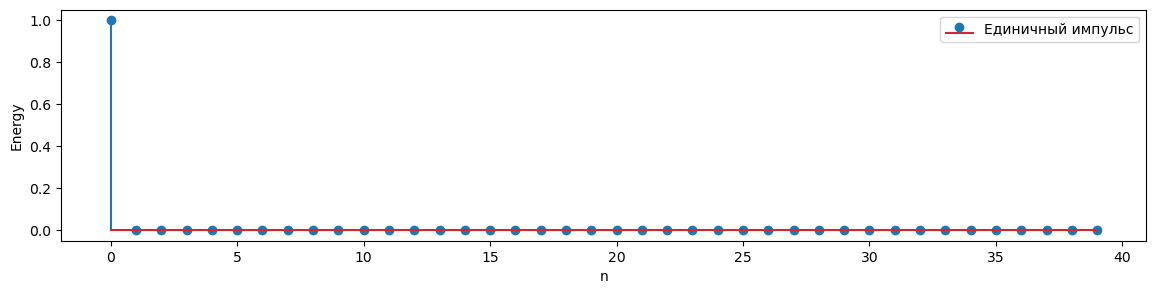

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

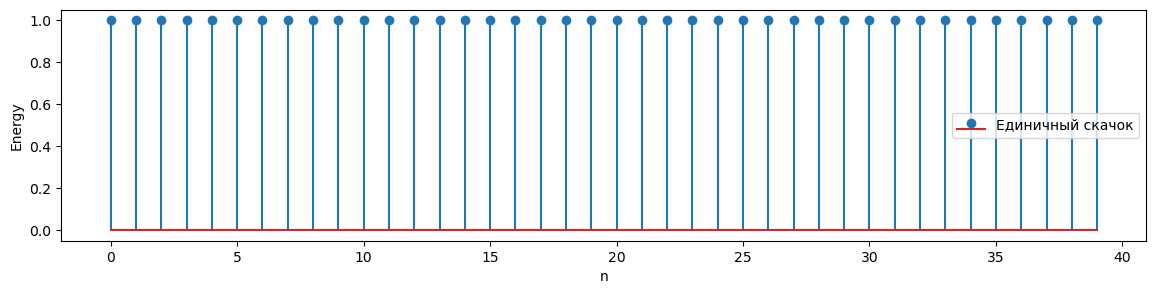

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

### Синус

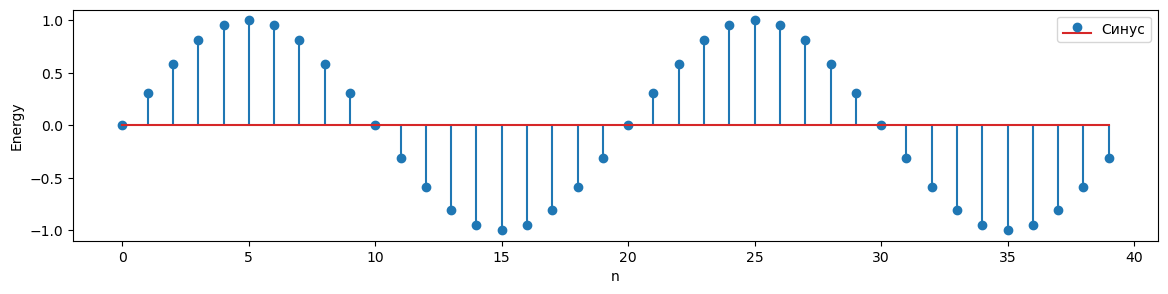

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

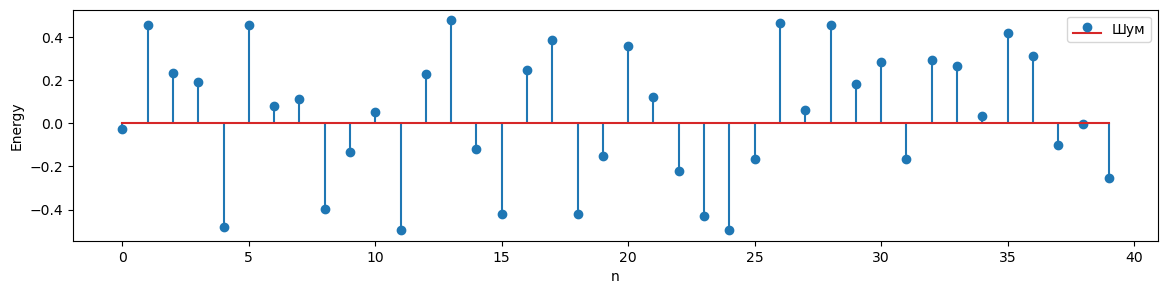

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [8]:
import math
import cmath
def DFT(x):
    N = len(x)
    result = []
    for k in range(N):
        sum_real = 0
        sum_imag = 0
        for n in range(N):
            angle = 2 * np.pi * k * n / N
            sum_real += x[n] * np.cos(angle)
            sum_imag += -x[n] * np.sin(angle)
        result.append(complex(sum_real, sum_imag))
    return np.array(result)
    raise NotImplementedError()

Сравнение с библиотекой scipy

In [9]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [83]:
def FFT(x):
    N = len(x)
    
    # Если длина сигнала меньше или равна 1, возвращаем сигнал
    if N <= 1:
        return x
    
    # Если длина не является степенью 2, дополнить нулями
    if N % 2 != 0:
        next_power_of_2 = 1 << (N - 1).bit_length()  # 2**ceil(log2(N))
        x = np.pad(x, (0, next_power_of_2 - N), mode='constant')
        N = next_power_of_2  # Обновляем N после дополнения

    # Разделение сигнала на четные и нечетные элементы
    even = FFT(x[0::2])   # Элементы с четными индексами
    odd = FFT(x[1::2])    # Элементы с нечетными индексами
    
    # Объединение результатов
    T = np.exp(-2j * np.pi * np.arange(N) / N) * odd
    return np.concatenate([even + T[:N // 2], even - T[:N // 2]])
    raise NotImplementedError()

In [84]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'


ValueError: operands could not be broadcast together with shapes (4,) (2,) 

Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [ ]:
# YOUR CODE HERE

# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [10]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    amplitude = np.abs(spec)
    return amplitude
    raise NotImplementedError()

#функция построения фазового спектра
def get_phi_from_spec(spec):
    phase = np.angle(spec)
    return phase

    raise NotImplementedError()

In [11]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [12]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

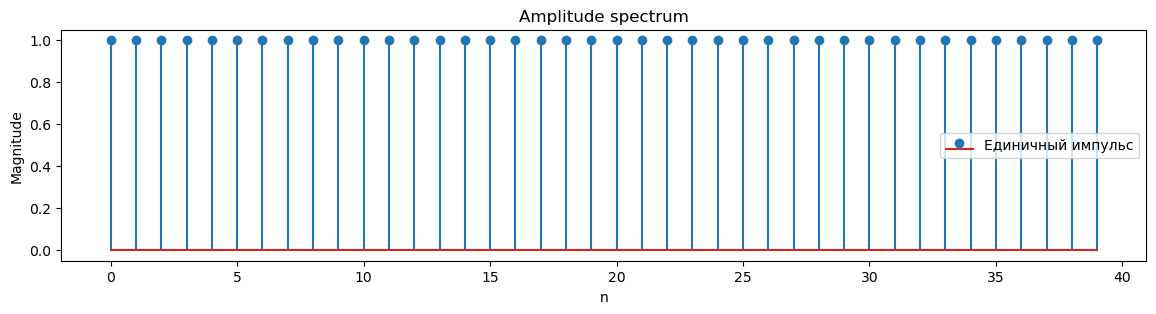

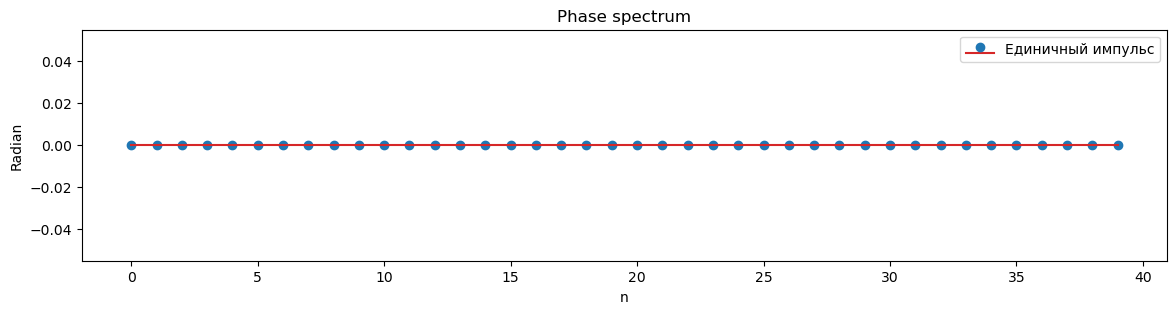

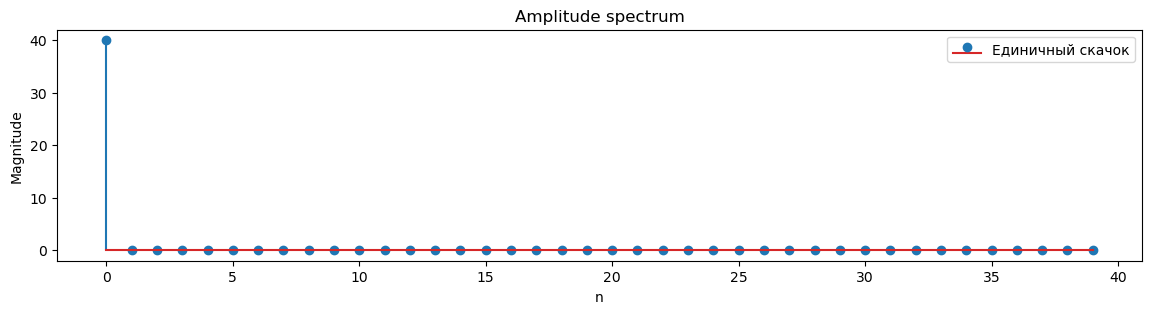

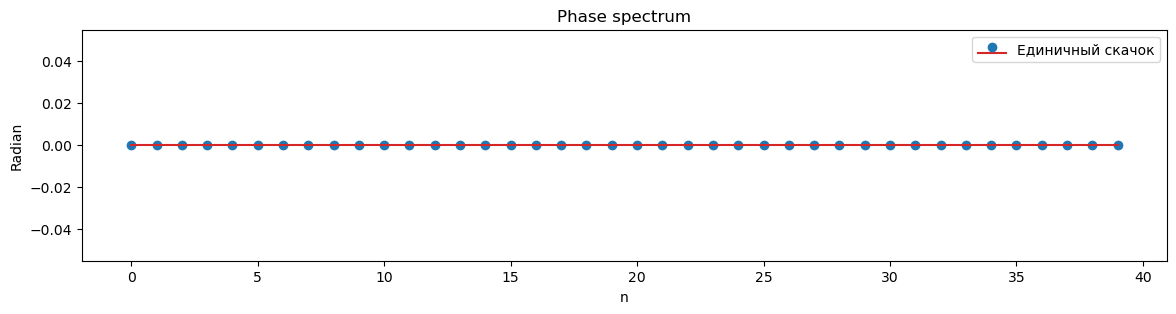

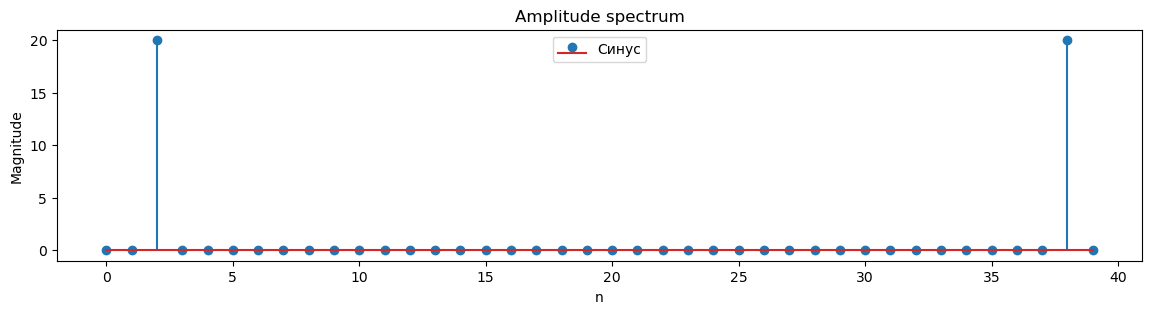

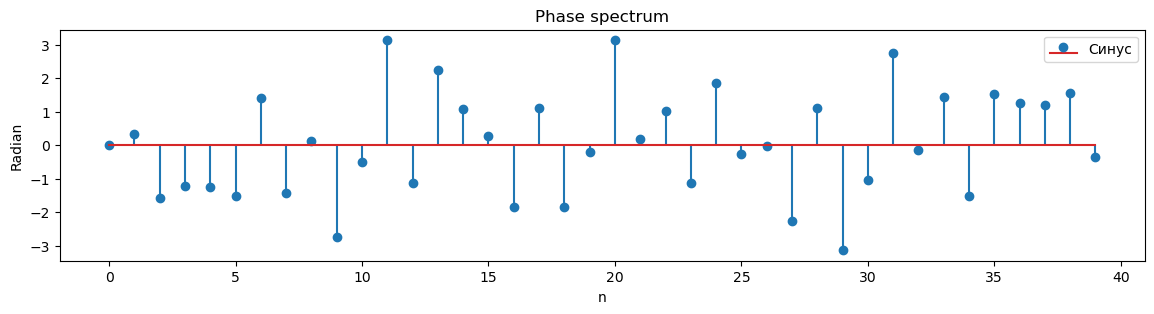

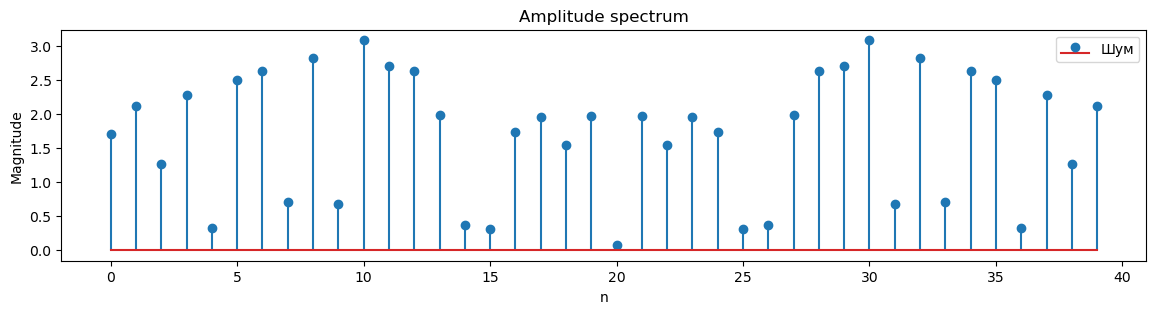

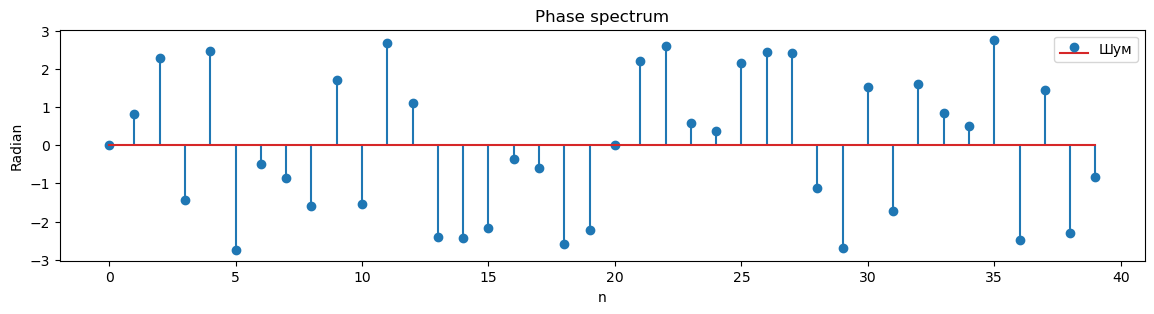

In [13]:
for name, signal in signals.items():
    fft_result = np.fft.fft(signal)
    draw_spec(fft_result, name=name)

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

Единичный импуль - дельта-функция Дирака, которая имеет бесконечно большую амплитуду в момент времени 𝑡=0 и нулевое значение в любое другое время. При этом его интеграл по всей оси времени равен единице. Дельта-функция передает всю свою энергию на все частоты. Т.к. она содержит все частоты (из-за ее бесконечной узкой формы), она представляет собой идеальный "фильтр", позволяющий всем частотам проходить без изменений. Это приводит к тому, что амплитуда всех гармоник будет одинаковой (константа), и  такая форма сигнала содержит все частоты в одинаковой степени.

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

Амплитудный спектр позволяет понять, какие частоты присутствуют в сигнале и насколько они выражены.
Фазовый спектр позволяет оценить, как различные частоты взаимодействуют между собой и как они влияют на форму сигнала.

### 3. Как перевести номер отсчета в частоту?

Чтобы перевести номер отсчета в частоту в контексте дискретного сигнала, вам нужно знать частоту дискретизации и номер отсчета (n). Формула для преобразования номера отсчета в частоту выглядит следующим образом: необходимо частоту дискретизации (в Гц) умножить на номер отсчета и разделить на общее количество отсчетов в сигнале.

### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

In [ ]:
# YOUR ANSWER HERE

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [14]:
from scipy.signal import get_window
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 

    if True:
        x = np.pad(x, (n_fft // 2, n_fft // 2), mode='constant')
    
    x_length = len(x)
    win = get_window(window, n_fft, fftbins=True)
    num_windows = (x_length - n_fft) // hop_length + 1
    stft_matrix = np.zeros((n_fft // 2 + 1, num_windows), dtype=complex)
    
    for i in range(num_windows):
        start = i * hop_length
        end = start + n_fft
        segment = x[start:end] * win 
        stft_matrix[:, i] = np.fft.rfft(segment) 

    return stft_matrix

    raise NotImplementedError()

In [15]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


Определим функцию для отрисовки

In [16]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


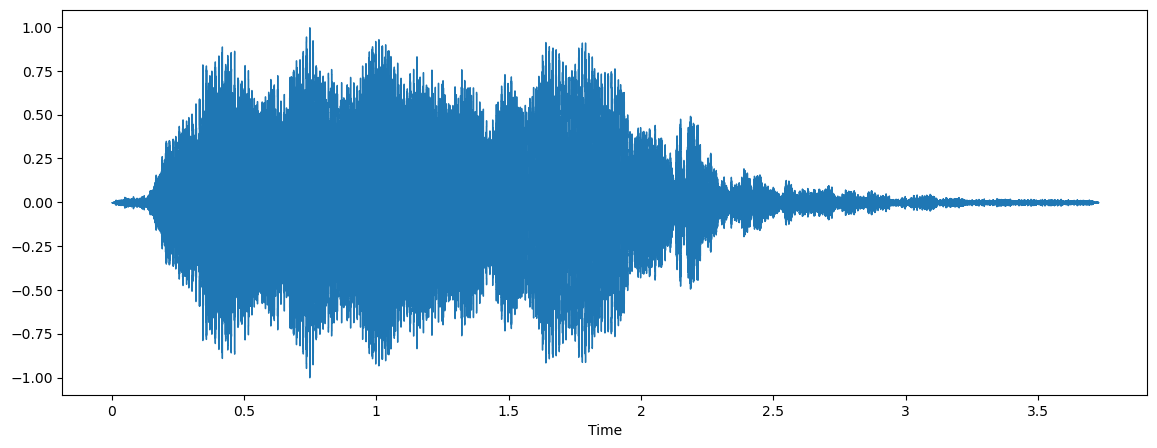

In [19]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


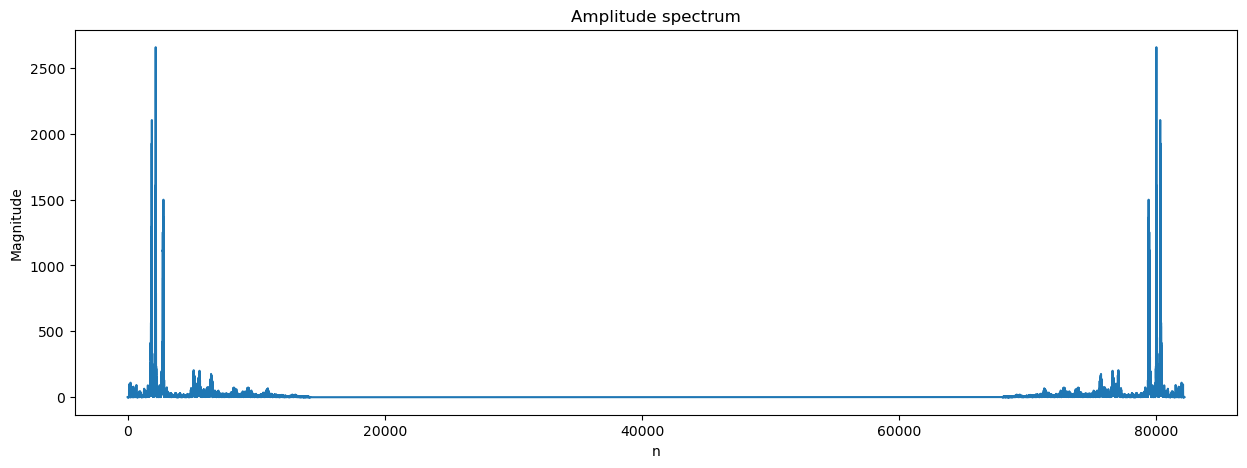

In [20]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

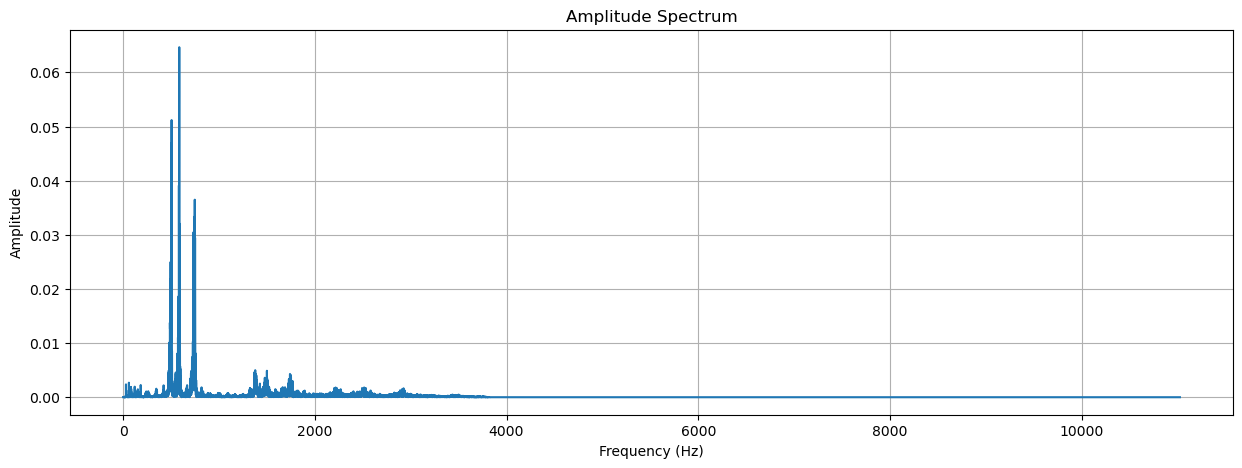

In [50]:
def draw_amp_spec(signal, tw_sr, figsize=(10, 4)):
    N = len(signal)
    T = 1.0 / tw_sr
    spectrum = scipy.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    yf = 2.0 / N * np.abs(spectrum[:N//2])
    plt.figure(figsize=figsize)
    plt.plot(xf, yf)
    plt.title("Amplitude Spectrum")
    plt.grid()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

draw_amp_spec(train_whistle, tw_sr, figsize=(15, 5))

### 1 гармоника

In [59]:
fft_result = np.fft.fft(train_whistle)
amplitudes = np.abs(fft_result)
freqs = np.fft.fftfreq(len(train_whistle), 1/tw_sr)
positive_freqs = freqs[:len(freqs)//2]
positive_amplitudes = amplitudes[:len(amplitudes)//2]
sorted_indices = np.argsort(positive_amplitudes)[::-1]
harmonics = positive_freqs[sorted_indices[:4
                                         ]]
harmonics = np.round(harmonics, 2)
print(harmonics[0])

585.76


### 2 гармоника

In [57]:
print(harmonics[2])

584.96


### 3 гармоника

In [60]:
print(harmonics[3])

505.8


### Тест

In [61]:
# task_answer = [ freq1, freq2, freq3 ]
task_answer = [585.76, 584.96, 505.8]

In [62]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [63]:
duration = 2.0
sampling_rate = 44100
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
task_answer = [585.76, 584.96, 505.8]
signal = np.zeros_like(t)
for harmonic in task_answer:
    signal += np.sin(2 * np.pi * harmonic * t)
signal /= np.max(np.abs(signal))
ipd.Audio(signal, rate=sampling_rate)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


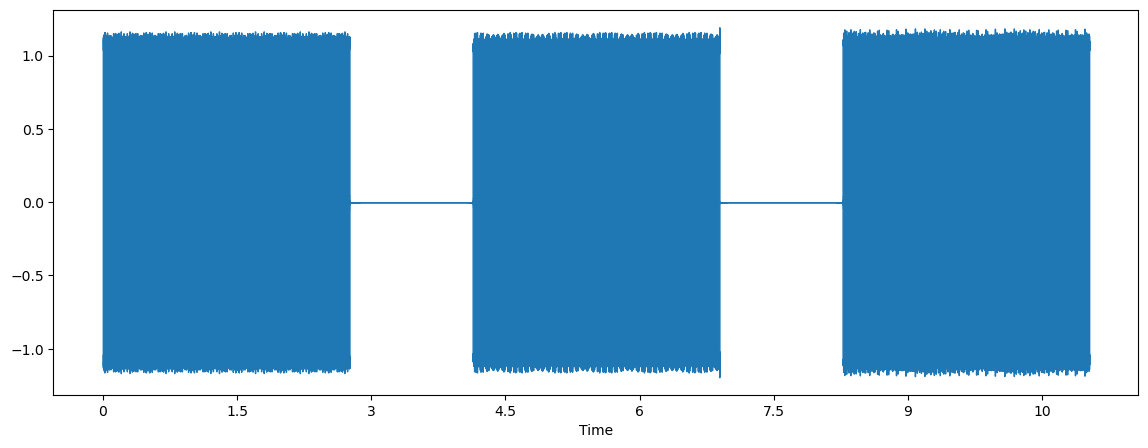

In [64]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [75]:
dtmf_freq_table = {
    (697, 1209): '1', (697, 1336): '2', (697, 1477): '3',
    (770, 1209): '4', (770, 1336): '5', (770, 1477): '6',
    (852, 1209): '7', (852, 1336): '8', (852, 1477): '9',
    (941, 1209): '*', (941, 1336): '0', (941, 1477): '#'
}

def analyze_dtmf_signal(signal, sr):
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/sr)
    positive_freqs = freqs[:len(freqs)//2]
    amplitudes = np.abs(fft_result)[:len(freqs)//2]
    sorted_indices = np.argsort(amplitudes)[::-1]
    main_freqs = positive_freqs[sorted_indices[:2]]
    main_freqs = np.round(main_freqs).astype(int)
    return tuple(sorted(main_freqs))

n_digits = 3
digit_duration = int(len(dtmf) / n_digits)

### 1 число

In [76]:
start = 0 * digit_duration
end = (0 + 1) * digit_duration
digit_signal = dtmf[start:end]
main_freqs = analyze_dtmf_signal(digit_signal, dtmf_sr)

if main_freqs in dtmf_freq_table:
    digit = dtmf_freq_table[main_freqs]
    decoded_number += digit
    print(f"Частоты для цифры {i+1}: {main_freqs} -> Цифра: {digit}")
else:
    print(f"Не удалось найти соответствие для частот: {main_freqs}")

Частоты для цифры 3: (697, 1209) -> Цифра: 1


### 2 число

In [77]:
start = 1 * digit_duration
end = (1 + 1) * digit_duration
digit_signal = dtmf[start:end]
main_freqs = analyze_dtmf_signal(digit_signal, dtmf_sr)

if main_freqs in dtmf_freq_table:
    digit = dtmf_freq_table[main_freqs]
    decoded_number += digit
    print(f"Частоты для цифры {i+1}: {main_freqs} -> Цифра: {digit}")
else:
    print(f"Не удалось найти соответствие для частот: {main_freqs}")

Частоты для цифры 3: (770, 1336) -> Цифра: 5


### 3 число

In [78]:
start = 2 * digit_duration
end = (2 + 1) * digit_duration
digit_signal = dtmf[start:end]
main_freqs = analyze_dtmf_signal(digit_signal, dtmf_sr)

if main_freqs in dtmf_freq_table:
    digit = dtmf_freq_table[main_freqs]
    decoded_number += digit
    print(f"Частоты для цифры {i+1}: {main_freqs} -> Цифра: {digit}")
else:
    print(f"Не удалось найти соответствие для частот: {main_freqs}")

Частоты для цифры 3: (852, 1477) -> Цифра: 9


### Тест

In [69]:
#phone_number = [first: int, second: int, third: int]
phone_number = [1, 5, 9]

In [70]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
